# Data cleaning and processing

In [2]:
import os, glob 
import sys
import numpy as np
from selenium import webdriver
import glob
import itertools
import urllib
import time
import cv2
from random import shuffle
import ffmpy
import matplotlib.pyplot as plt
import keras
import imp
#import label_data
import imp
import pandas as pd
#imp.reload(label_data)
%matplotlib inline
import scipy.misc
from sklearn.model_selection import train_test_split
from keras import utils 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, normalize 
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, lars_path, Lasso, LassoCV,RidgeCV,Ridge
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


** DATA CHECKING**<br>
In this part, we did the following jobs:<br>
1. Examine the number of images in train set for each simpson character, for those characters with very small size of images, we decided to dropped them, i.e. we only use the 13 characters with the top largest 13 amount of images in train set.<br>
2. Examine the number of images in test set (similar amount), also sneak a peek of what the images look like.<br>
3. Load train and test data: perform grayscale normalization to reduce the effect of illumination's different.

simpsons_dataset   1
simpsons_dataset/abraham_grampa_simpson   913
simpsons_dataset/agnes_skinner   42
simpsons_dataset/apu_nahasapeemapetilon   623
simpsons_dataset/barney_gumble   106
simpsons_dataset/bart_simpson   1342
simpsons_dataset/bumblebee_man   0
simpsons_dataset/carl_carlson   98
simpsons_dataset/charles_montgomery_burns   1193
simpsons_dataset/chief_wiggum   986
simpsons_dataset/cletus_spuckler   47
simpsons_dataset/comic_book_guy   469
simpsons_dataset/disco_stu   8
simpsons_dataset/edna_krabappel   457
simpsons_dataset/fat_tony   27
simpsons_dataset/gil   27
simpsons_dataset/groundskeeper_willie   121
simpsons_dataset/hans_moleman   0
simpsons_dataset/helen_lovejoy   0
simpsons_dataset/homer_simpson   2246
simpsons_dataset/jasper_beardly   0
simpsons_dataset/jimbo_jones   0
simpsons_dataset/kent_brockman   498
simpsons_dataset/krusty_the_clown   1206
simpsons_dataset/lenny_leonard   310
simpsons_dataset/lionel_hutz   3
simpsons_dataset/lisa_simpson   1354
simpsons_datase

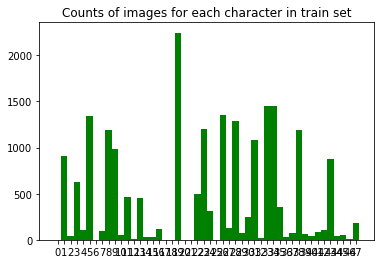

Top 13 characters: ['abraham_grampa_simpson', 'bart_simpson', 'charles_montgomery_burns', 'chief_wiggum', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner', 'sideshow_bob']


In [3]:

#=====================check number of images in train set for each simpson character ===========================#
subfolder_name = [dI for dI in os.listdir('simpsons_dataset') if os.path.isdir(os.path.join('simpsons_dataset',dI))]

num_images_each_character = []
for dir,subdir,files in os.walk('simpsons_dataset'):
    print(dir,' ', str(len(files)))
    num_images_each_character.append(len(files))


# ===================== Counts of images for each character in train set ======================================#
freq = num_images_each_character
xlab = list(range(len(num_images_each_character)))
ax = plt.axes()
ax.set_xticks(xlab)
ax.set_xticklabels(xlab)
plt.bar(xlab, freq, 1.0, color='g')
plt.title('Counts of images for each character in train set')
plt.show()


# =====================get the 13 characters which has the largest images in train set==========================#
index = sorted(np.argsort(num_images_each_character)[-13:])
dict_character = []
for i in range(13):
    dict_character.append(subfolder_name[index[i]-1])
print('Top 13 characters:',dict_character)

In [4]:
# these are the 13 characters with most amount of images.
#therefore we will only include them in the model.

dict_characters = {0: 'abraham_grampa_simpson',  1: 'bart_simpson', 
                   2: 'charles_montgomery_burns', 3: 'chief_wiggum', 4: 'homer_simpson',  5: 'krusty_the_clown', 
                   6:'lisa_simpson', 7: 'marge_simpson', 8:'milhouse_van_houten', 9: 'moe_szyslak', 
                   10: 'ned_flanders',  11: 'principal_skinner', 12: 'sideshow_bob'}

In [5]:
# delete the imgaes of thoes characters we dont use in test dataset
# and examine the remaining test set

from collections import Counter
full_character_name = []
for image_name in os.listdir("kaggle_simpson_testset")[1:]:
    full_character_name.append("_".join(image_name.split('_')[:-1]))
full_character_name 
Counter(full_character_name )

Counter({'abraham_grampa_simpson': 48,
         'bart_simpson': 50,
         'charles_montgomery_burns': 48,
         'chief_wiggum': 50,
         'homer_simpson': 50,
         'krusty_the_clown': 50,
         'lisa_simpson': 50,
         'marge_simpson': 50,
         'milhouse_van_houten': 49,
         'moe_szyslak': 50,
         'ned_flanders': 49,
         'principal_skinner': 50,
         'sideshow_bob': 47})

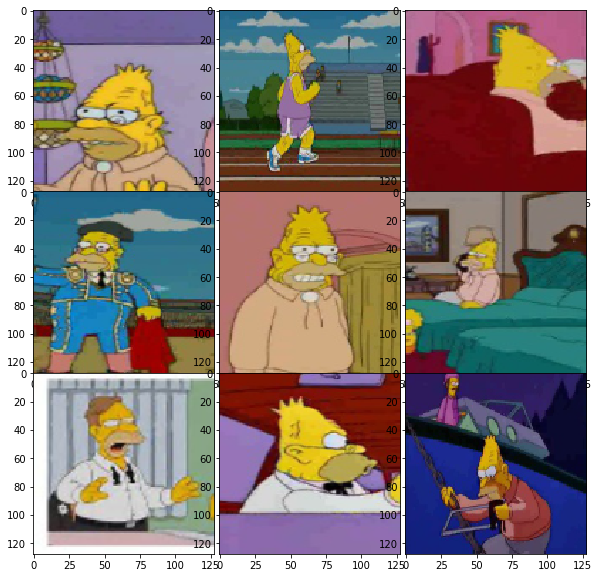

In [6]:
# sneak peek of what the images look like

print_image = glob.glob('kaggle_simpson_testset/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in print_image[:9]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(3, 3, i+1) 
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    i = i + 1

In [9]:
# load train and test data

# =======================================test dataset=====================================================
#img_size = 64
img_rows = 64
img_cols = 64
def test_get(dirname,dict_characters):
    X_test = []
    Y_test = []
    for image_name in os.listdir(dirname)[1:]:
        character_name = "_".join(image_name.split('_')[:-1])
        label = [label for label,character in dict_characters.items() if character == character_name][0]
        image = scipy.misc.imread(dirname+'/'+image_name)
        X_test.append(scipy.misc.imresize(image,(img_rows,img_cols),interp='lanczos'))
        Y_test.append(label)
    return np.array(X_test), np.array(Y_test)
X_test, Y_test = test_get("kaggle_simpson_testset", dict_characters) 
# Normalize 
X_test = X_test / 255.0

print("Test", X_test.shape, Y_test.shape)

# =======================================train dataset=====================================================
from os import listdir
directory_name = "simpsons_dataset"

def train_get(dirname,dict_characters):
    X_train = []
    Y_train = []
    for label,character in dict_characters.items():
        list_images = os.listdir(dirname+'/'+character)
        
        # pick number of images we want to use
        for image_name in list_images[0:1000]:
            image = scipy.misc.imread(dirname+'/'+character+'/'+image_name)
            X_train.append(scipy.misc.imresize(image,(img_rows,img_cols),interp='lanczos'))
            Y_train.append(label)
    return np.array(X_train), np.array(Y_train)
X_train, Y_train = train_get("simpsons_dataset", dict_characters)       
# Normalize the data
X_train = X_train / 255.0
print("Train", X_train.shape, Y_train.shape)

Test (641, 64, 64, 3) (641,)
Train (12776, 64, 64, 3) (12776,)


In [10]:
# change x_train to 2d: (3000,64*64*3)
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

# Encode labels to hot vectors 
Y_trainHot = utils.to_categorical(Y_train, num_classes = len(dict_characters))
Y_testHot = utils.to_categorical(Y_test, num_classes = len(dict_characters))
print(Y_trainHot.shape, Y_testHot.shape)

(12776, 13) (641, 13)
